In [102]:
import numpy as np
import pandas as pd

# from autograd import numpy as ag  # import numpy from autograd for automatic differentiation
from autograd import grad        # for computing gradients
from autograd import numpy as ag  # import numpy from autograd for automatic differentiation
from autograd import elementwise_grad
import scipy.special as sp

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="darkgrid", palette = "bright", font = "Helvetica")

import warnings
warnings.filterwarnings("ignore")

## Problem 1

In [161]:
region_colors = {
    'inactive learning region': 'blue',
    'slow learning region': 'green',
    'active learning region': 'orange',
    'fast learning region': 'red'
}

def plot_f(df):

    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))

    # Plot the sigmoid function in the first subplot
    sns.lineplot(data = df, x="x", y="y", ax=axes[0], label='region')
    axes[0].set_title('Function')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')

    # Plot the gradient of the sigmoid function in the second subplot
    sns.lineplot(data = df, x="x", y="y_g", ax=axes[1], label='region')
    axes[1].set_title('Function Gradient')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel("y")

    # Adjust layout for better spacing between the plots
    plt.tight_layout()
    plt.show()


# plot_f(x_values, sigmoid_values, gradient_values)

In [162]:
# 1. ReLU
def relu(z):
    return ag.maximum(0, z)

# 2. Logistic Sigmoid Activation Function
def sigmoid(z):
    return 1 / (1 + ag.exp(-z))

# 3. Piecewise Linear Unit
def piecewise_linear(z):
    return ag.where(z < -1, 0.2*z - 0.8, ag.where(z < 1, z, 0.2*z + 0.8))
    # return ag.where(ag.logical_and(z >= -1, z <= 1), z, 0.2*z - 0.8)

# 4. Swish
def swish(z, a=1):
    return z * sigmoid(a * z)

# 5. Exponential Linear Unit (ELU)
def elu(z, a=1):
    return ag.where(z >= 0, z, a * (ag.exp(z) - 1))

# 6. Gaussian Error Linear Unit (GELU)
def gelu(x):
    return 0.5 * x * (1 + ag.tanh(ag.sqrt(2 / ag.pi) * (x + 0.044715 * x**3)))





def get_activation_output_and_gradients(x_values, activation_function):
    # Check the activation function name and call the corresponding function
    if activation_function == 'ReLU':
        y = relu(x_values)
        relu_grad = elementwise_grad(relu)
        y_grad = relu_grad(x_values)
    elif activation_function == 'Logistic_Sigmoid':
        y = sigmoid(x_values)
        logistic_sigmoid_grad = elementwise_grad(sigmoid)
        y_grad = logistic_sigmoid_grad(x_values)
    elif activation_function == 'Piecewise_Linear':
        y = piecewise_linear(x_values)
        piecewise_linear_grad = elementwise_grad(piecewise_linear)
        y_grad = piecewise_linear_grad(x_values)
    elif activation_function == 'Swish':
        y = swish(x_values)
        swish_grad = elementwise_grad(swish)
        y_grad = swish_grad(x_values)
    elif activation_function == 'ELU':
        y = elu(x_values)
        elu_grad = elementwise_grad(elu)
        y_grad = elu_grad(x_values)
    elif activation_function == 'GELU':
        y = gelu(x_values)
        gelu_grad = elementwise_grad(gelu)
        y_grad = gelu_grad(x_values)
    else:
        raise ValueError("Unknown activation function: " + activation_function)
    
    return x_values, y, y_grad


In [169]:
x_values = np.linspace(-5, 5, 100)
x, y, y_g = get_activation_output_and_gradients(x_values, "GELU")

In [170]:
df = pd.DataFrame({"x":x, "y":y, "y_g":y_g})
df["grad_magnitude"] = df.y_g.apply(lambda x: max(x, -1*x))

# Define custom bins and labels
bins = [-float('inf'), 0, 0.01, 0.99, float('inf')]  # Edges of buckets
labels = ['inactive learning region', 'slow learning region', 'active learning region', 'fast learning region']

# Assign each value to a bucket
df['region'] = pd.cut(df['grad_magnitude'], bins=bins, labels=labels, right=False)

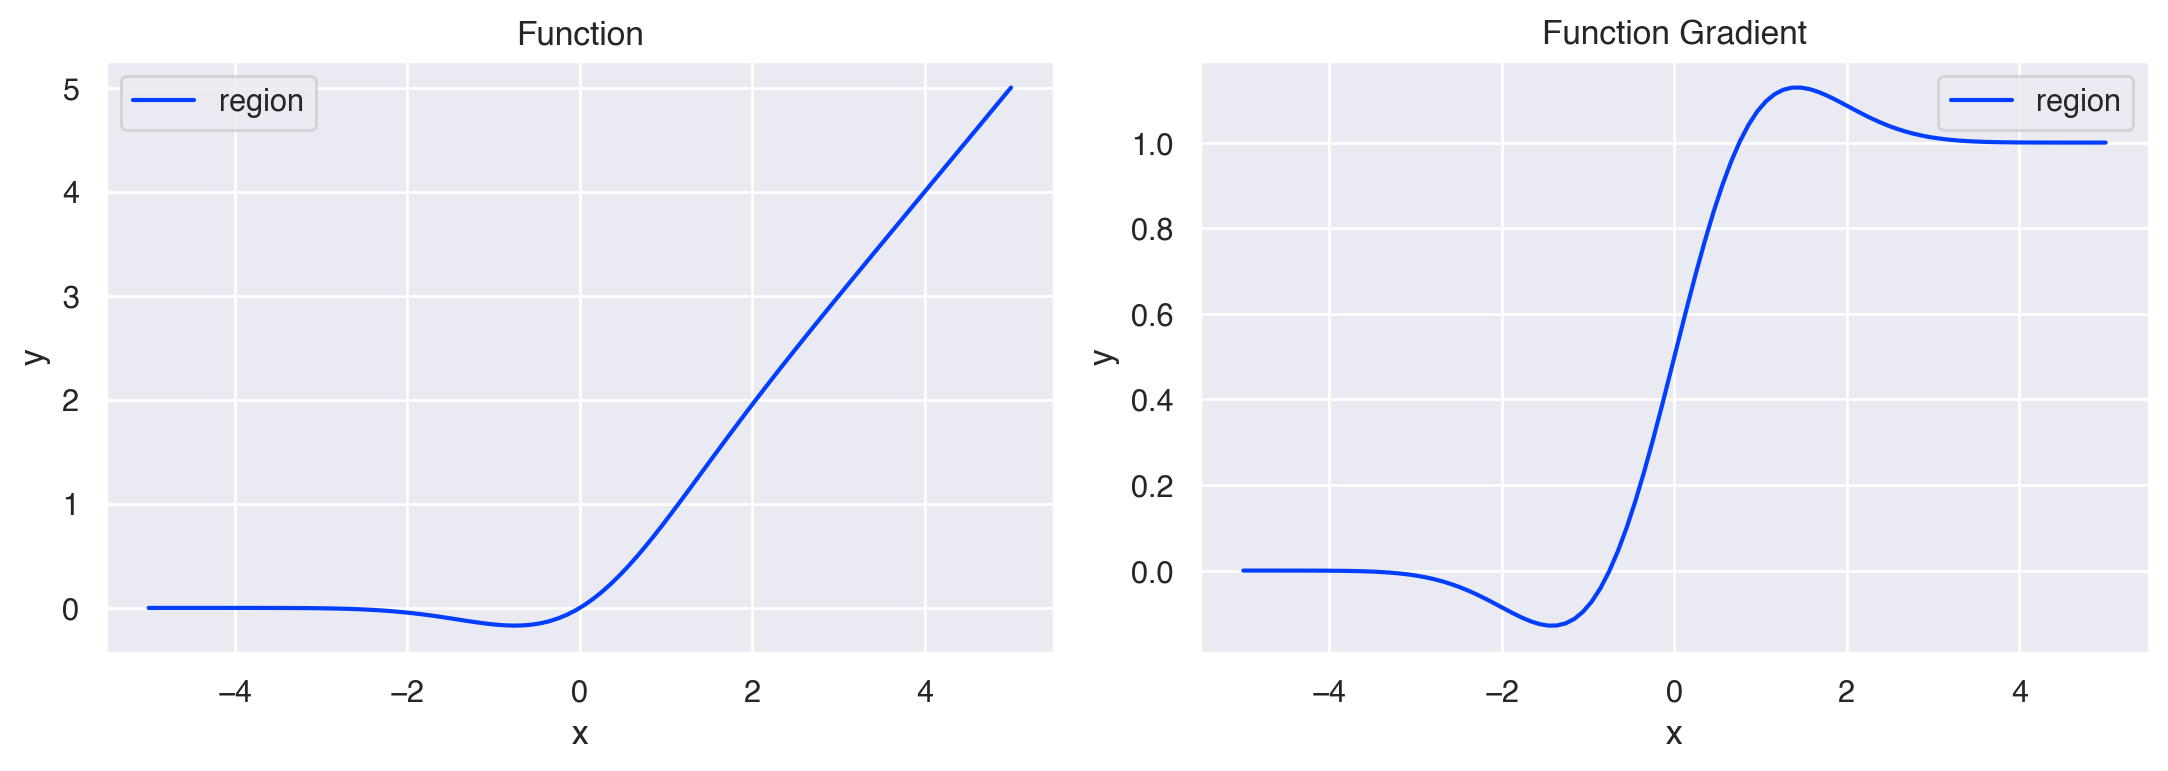

In [171]:
plot_f(df)

In [172]:
# Create a dictionary to store the ranges for each region
region_ranges = {}

for region in df["region"].unique():
    region_df = df[df["region"] == region]

    # Identify distinct contiguous subregions
    subregions = []
    sorted_x = sorted(region_df["x"].unique())

    start = sorted_x[0]
    prev = start

    for x in sorted_x[1:]:
        if x - prev > (sorted_x[1] - sorted_x[0]) * 1.5:  # Detecting gaps
            subregions.append((start, prev))
            start = x
        prev = x

    subregions.append((start, prev))  # Add the last segment
    y_range = (region_df["y_g"].min(), region_df["y_g"].max())

    region_ranges[region] = {"x_ranges": subregions, "y_g_range": y_range}

# Convert to DataFrame for better visualization
region_ranges_df = pd.DataFrame.from_dict(region_ranges, orient="index")

# Display the results
region_ranges_df

,x_ranges,y_g_range
slow learning region,"[(-5.0, -3.080808080808081), (-0.7575757575757...","(-0.009235934341943638, -1.546361987519936e-06)"
active learning region,"[(-2.9797979797979797, -0.858585858585859), (-...","(-0.12857121185337894, 0.9551865081937392)"
fast learning region,"[(0.7575757575757578, 5.0)]","(1.0000015463619876, 1.128571211853379)"


In [173]:
region_ranges_df.iloc[0,0]

[(np.float64(-5.0), np.float64(-3.080808080808081)),
 (np.float64(-0.7575757575757578), np.float64(-0.7575757575757578))]

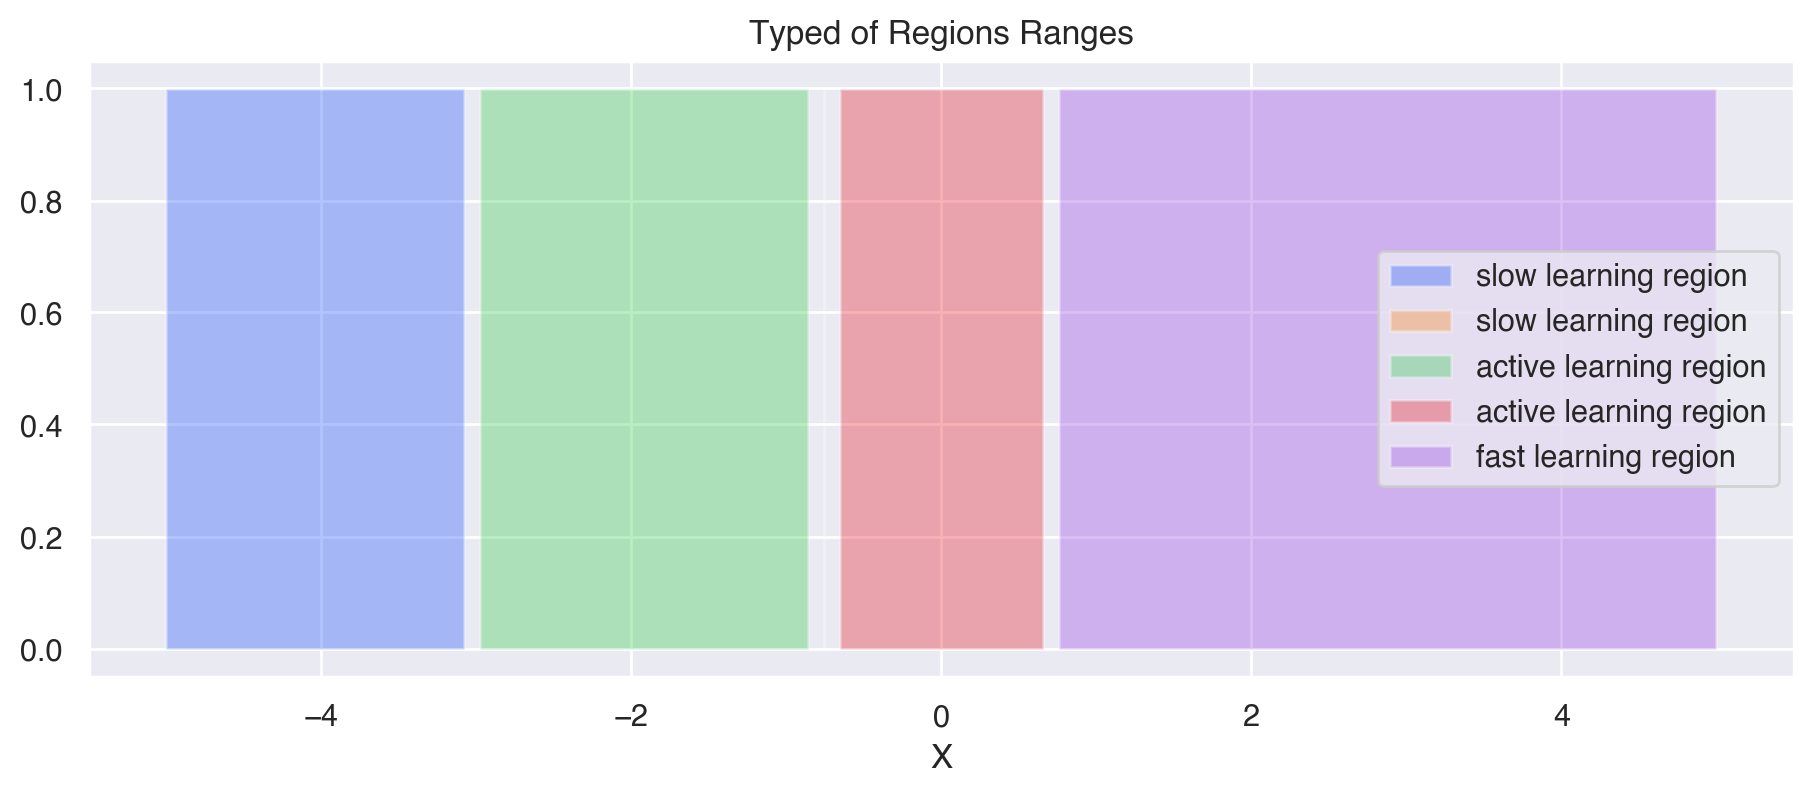

In [174]:
# Create a dictionary to store the ranges for each region
region_ranges = {}

for region in df["region"].unique():
    region_df = df[df["region"] == region]

    # Identify distinct contiguous subregions
    subregions = []
    sorted_x = sorted(region_df["x"].unique())

    start = sorted_x[0]
    prev = start

    for x in sorted_x[1:]:
        if x - prev > (sorted_x[1] - sorted_x[0]) * 1.5:  # Detecting gaps
            subregions.append((start, prev))
            start = x
        prev = x

    subregions.append((start, prev))  # Add the last segment
    y_range = (region_df["y"].min(), region_df["y"].max())

    region_ranges[region] = {"x_ranges": subregions, "y_range": y_range}

# Convert to DataFrame for better visualization
region_ranges_df = pd.DataFrame.from_dict(region_ranges, orient="index")

# Plot the data for visualization
plt.figure(figsize=(11, 4))

for region, values in region_ranges.items():
    y_min, y_max = values["y_range"]
    for x_min, x_max in values["x_ranges"]:
        plt.fill_between([x_min, x_max], 0, 1, alpha=0.3, label=region)

plt.xlabel("X")
plt.ylabel("")
plt.title("Typed of Regions Ranges")
plt.legend()
plt.grid(True)
plt.show()

## Problem 2

In [81]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Initialize parameters
W = np.array([[1, 1],
              [1, 1]], dtype=float)    
c = np.array([0, -1], dtype=float)     
w = np.array([1, -2], dtype=float)     
b = -0.5                               


data = [
    (np.array([0, 0], dtype=float), 0),
    (np.array([0, 1], dtype=float), 1),
    (np.array([1, 0], dtype=float), 1),
    (np.array([1, 1], dtype=float), 0)
]

### 2.1

In [82]:
for i, (x, y) in enumerate(data):
    # Hidden layer: pre-activation and activation (ReLU)
    a_hidden = np.dot(W, x) + c         # a_hidden = W*x + c
    h = np.maximum(0, a_hidden)           # ReLU: h = max(0, a_hidden)
    
    # Output layer: pre-activation and activation (sigmoid)
    a_out = np.dot(w, h) + b              # a_out = w^T * h + b
    y_hat = sigmoid(a_out)                # y_hat = σ(a_out)
    
    # Cross-entropy loss: L = -[y log(y_hat) + (1-y) log(1-y_hat)]
    loss = - (y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    
    print(f"Sample {i+1}: x = {x}, target = {y}")
    print(f"  y_hat (sigmoid output): {y_hat:.4f}")
    print(f"  Loss: {loss:.4f}\n")


Sample 1: x = [0. 0.], target = 0
  y_hat (sigmoid output): 0.3775
  Loss: 0.4741

Sample 2: x = [0. 1.], target = 1
  y_hat (sigmoid output): 0.6225
  Loss: 0.4741

Sample 3: x = [1. 0.], target = 1
  y_hat (sigmoid output): 0.6225
  Loss: 0.4741

Sample 4: x = [1. 1.], target = 0
  y_hat (sigmoid output): 0.3775
  Loss: 0.4741



### 2.2

In [84]:
for i, (x, y) in enumerate(data):
    # --- Forward pass to obtain activations ---
    a_hidden = np.dot(W, x) + c         
    h = np.maximum(0, a_hidden)           
    a_out = np.dot(w, h) + b              
    y_hat = sigmoid(a_out)                


    # --- Backward pass ---
    delta_out = y_hat - y

    grad_w = delta_out * h                
    grad_b = delta_out                    

    # backpropagating into hidden layer
    relu_grad = (a_hidden > 0).astype(float) 
    delta_hidden = (delta_out * w) * relu_grad

    grad_W = np.outer(delta_hidden, x)    # Outer product: delta_hidden_i * x_j
    grad_c = delta_hidden                 # ∇_c = delta_hidden


    print(f"Sample {i+1}: x = {x}, target = {y}")
    print(f"  grad_w: {grad_w}")
    print(f"  grad_b: {grad_b}")
    print(f"  grad_W:\n{grad_W}")
    print(f"  grad_c: {grad_c}\n")


Sample 1: x = [0. 0.], target = 0
  grad_w: [0. 0.]
  grad_b: 0.3775406687981454
  grad_W:
[[ 0.  0.]
 [-0. -0.]]
  grad_c: [ 0. -0.]

Sample 2: x = [0. 1.], target = 1
  grad_w: [-0.37754067 -0.        ]
  grad_b: -0.3775406687981454
  grad_W:
[[-0.         -0.37754067]
 [ 0.          0.        ]]
  grad_c: [-0.37754067  0.        ]

Sample 3: x = [1. 0.], target = 1
  grad_w: [-0.37754067 -0.        ]
  grad_b: -0.3775406687981454
  grad_W:
[[-0.37754067 -0.        ]
 [ 0.          0.        ]]
  grad_c: [-0.37754067  0.        ]

Sample 4: x = [1. 1.], target = 0
  grad_w: [0.75508134 0.37754067]
  grad_b: 0.3775406687981454
  grad_W:
[[ 0.37754067  0.37754067]
 [-0.75508134 -0.75508134]]
  grad_c: [ 0.37754067 -0.75508134]



## Problem 3

In [175]:
# ======================
# Define the XOR Network
# ======================
class XORNet(nn.Module):
    def __init__(self):
        super(XORNet, self).__init__()
        # Hidden layer: 2 inputs -> 2 hidden units
        self.hidden = nn.Linear(2, 2)
        # Output layer: 2 hidden units -> 1 output
        self.out = nn.Linear(2, 1)
        # Manually initialize parameters as given:
        with torch.no_grad():
            # For hidden layer, weight matrix is 2x2 and bias is 2-dim.
            self.hidden.weight.copy_(torch.tensor([[1.0, 1.0],
                                                     [1.0, 1.0]]))
            self.hidden.bias.copy_(torch.tensor([0.0, -1.0]))
            # For output layer, weight shape (1,2) and bias is a scalar.
            self.out.weight.copy_(torch.tensor([[1.0, -2.0]]))
            self.out.bias.copy_(torch.tensor([-0.5]))
    
    def forward(self, x):
        h = torch.relu(self.hidden(x))
        y_hat = torch.sigmoid(self.out(h))
        return y_hat

    # A helper to return intermediate values (for verification)
    def forward_debug(self, x):
        a_hidden = self.hidden(x)
        h = torch.relu(a_hidden)
        a_out = self.out(h)
        y_hat = torch.sigmoid(a_out)
        return a_hidden, h, a_out, y_hat

# ===============================
# Prepare the XOR Training Dataset
# ===============================
# Four XOR points: (x1,x2) with target y
# 0⊕0 = 0, 0⊕1 = 1, 1⊕0 = 1, 1⊕1 = 0
train_data = [
    (torch.tensor([0.0, 0.0]), torch.tensor([0.0])),
    (torch.tensor([0.0, 1.0]), torch.tensor([1.0])),
    (torch.tensor([1.0, 0.0]), torch.tensor([1.0])),
    (torch.tensor([1.0, 1.0]), torch.tensor([0.0]))
]

### 3.1

In [176]:
# Verifying Forward Propagation
model_initial = XORNet()  # initial network

for i, (x, y) in enumerate(train_data):
    # Reshape x to be (1,2)
    x_in = x.unsqueeze(0)
    a_hidden, h, a_out, y_hat = model_initial.forward_debug(x_in)
    # Compute cross-entropy loss for binary classification:
    # L = -[y log(y_hat) + (1-y) log(1-y_hat)]
    loss = - (y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))
    print(f"Sample {i+1}: input {x.numpy()}, target {y.item()}")
    print(f"  a_hidden: {a_hidden.detach().numpy()}")
    print(f"  h (ReLU): {h.detach().numpy()}")
    print(f"  a_out: {a_out.detach().numpy()}")
    print(f"  y_hat: {y_hat.item():.4f}")
    print(f"  Loss: {loss.item():.4f}\n")

Sample 1: input [0. 0.], target 0.0
  a_hidden: [[ 0. -1.]]
  h (ReLU): [[0. 0.]]
  a_out: [[-0.5]]
  y_hat: 0.3775
  Loss: 0.4741

Sample 2: input [0. 1.], target 1.0
  a_hidden: [[1. 0.]]
  h (ReLU): [[1. 0.]]
  a_out: [[0.5]]
  y_hat: 0.6225
  Loss: 0.4741

Sample 3: input [1. 0.], target 1.0
  a_hidden: [[1. 0.]]
  h (ReLU): [[1. 0.]]
  a_out: [[0.5]]
  y_hat: 0.6225
  Loss: 0.4741

Sample 4: input [1. 1.], target 0.0
  a_hidden: [[2. 1.]]
  h (ReLU): [[2. 1.]]
  a_out: [[-0.5]]
  y_hat: 0.3775
  Loss: 0.4741



### 3.2

=== (2) Training ===
Epoch  10: Avg Loss = 0.4794
Epoch  20: Avg Loss = 0.3996
Epoch  30: Avg Loss = 0.3168
Epoch  40: Avg Loss = 0.2809
Epoch  50: Avg Loss = 0.2393
Epoch  60: Avg Loss = 0.1973
Epoch  70: Avg Loss = 0.1756
Epoch  80: Avg Loss = 0.1528
Epoch  90: Avg Loss = 0.1258
Epoch 100: Avg Loss = 0.1137


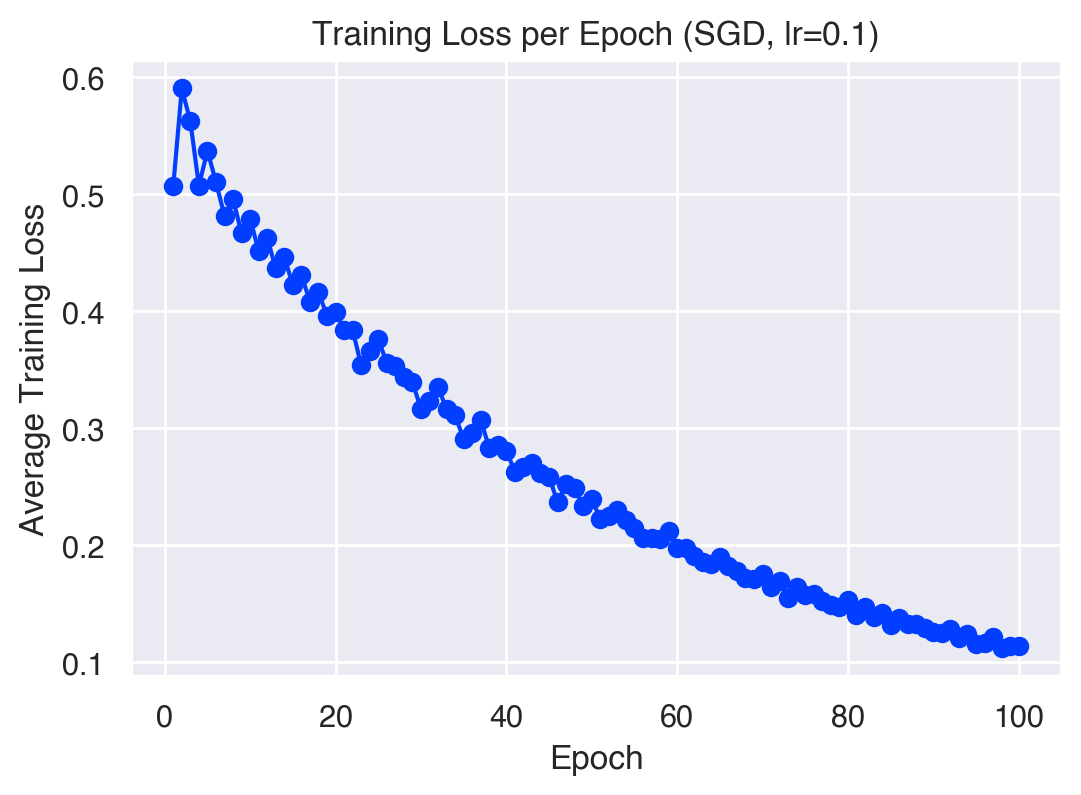

The training loss curve shows how gradient descent gradually reduces the loss over epochs


In [177]:
# Training
model = XORNet()
criterion = nn.BCELoss()  # binary cross-entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.1)

num_epochs = 100
loss_history = []

print("=== (2) Training ===")
for epoch in range(1, num_epochs+1):
    epoch_loss = 0.0
    # For each training sample (batch size = 1)
    for x, y in train_data:
        x_in = x.unsqueeze(0)  # shape: (1,2)
        y_target = y.unsqueeze(0)  # shape: (1,)
        optimizer.zero_grad()
        y_pred = model(x_in)
        loss = criterion(y_pred, y_target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_data)
    loss_history.append(avg_loss)
    # Optionally print every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: Avg Loss = {avg_loss:.4f}")

sns.set_style("whitegrid")
# Plot training loss vs. epoch
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("Training Loss per Epoch (SGD, lr=0.1)")
plt.grid(True)
plt.show()

print("The training loss curve shows how gradient descent gradually reduces the loss over epochs")